In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

import matplotlib as mpl

mpl.rcParams["hatch.linewidth"] = 3.0

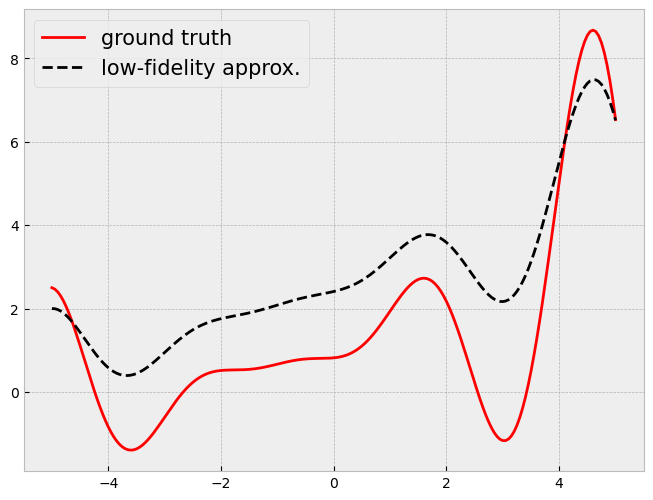

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
fidelities = torch.tensor([0.5, 1.0])

xs = torch.linspace(lb, ub, 201)

ys = objective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [3]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [4]:
n = 10

torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1)
train_f = fidelities[torch.randint(2, (n, 1))]  # mixed fidelity
# train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = torch.cat([train_x, train_f], dim=1)
train_x_full

tensor([[-0.0374,  1.0000],
        [ 2.6822,  0.5000],
        [-4.1152,  0.5000],
        [-3.6797,  1.0000],
        [-1.9258,  0.5000],
        [ 1.3408,  0.5000],
        [-0.0991,  0.5000],
        [ 3.9644,  0.5000],
        [-0.4437,  0.5000],
        [ 1.3231,  1.0000]])

In [5]:
train_y = []
for x in train_x_full:
    if torch.isclose(x[-1], torch.ones(1)):
        train_y.append(objective(x[:-1]))
    else:
        train_y.append(approx_objective(x[:-1]))

train_y = torch.tensor(train_y).unsqueeze(-1)
train_y

tensor([[ 0.8137],
        [ 2.4210],
        [ 0.7342],
        [-1.3725],
        [ 1.7799],
        [ 3.6063],
        [ 2.3797],
        [ 5.3423],
        [ 2.2874],
        [ 2.5180]])

In [6]:
model = SingleTaskMultiFidelityGP(train_x_full, train_y, data_fidelity=1)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [7]:
with torch.no_grad():
    pred_dist = model(torch.vstack([xs, torch.ones_like(xs)]).T)
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()

    # approx_pred_dist = model(torch.vstack([xs, torch.ones_like(xs) * 0.5]).T)
    # approx_pred_mean = approx_pred_dist.mean
    # approx_pred_lower, approx_pred_upper = approx_pred_dist.confidence_region()

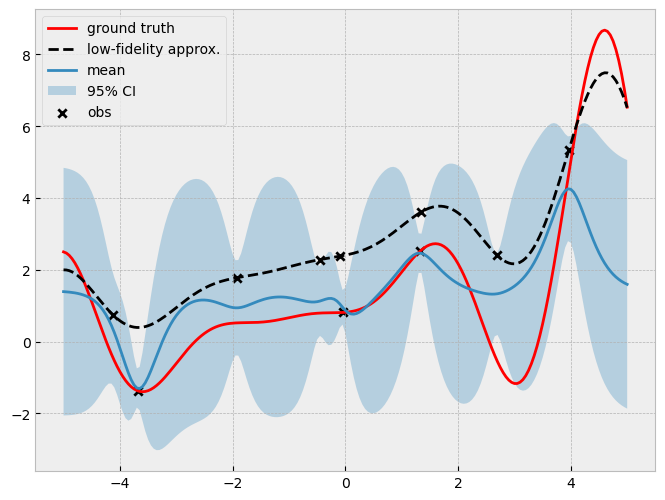

In [8]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

# plt.plot(xs, approx_pred_mean, c="orange", label="low-fidelity mean")
# plt.fill_between(
#     xs.flatten(),
#     approx_pred_lower,
#     approx_pred_upper,
#     color="orange",
#     alpha=0.3,
#     label="low-fidelity 95% CI",
# )

plt.scatter(train_x, train_y, c="k", marker="x", label="obs")

plt.legend();

## 9.3 Balancing information and cost in multi-fidelity optimization

### 9.3.1 Modeling the costs of querying different fidelities

In [9]:
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from torch.quasirandom import SobolEngine
from botorch.acquisition.utils import project_to_target_fidelity


cost_model = AffineFidelityCostModel(fixed_cost=10.0, fidelity_weights={1: 1.0})

### 9.3.2 Optimizing the amount of information per dollar to guide optimization

In [10]:
num_samples = 1000
torch.manual_seed(0)

cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

sobol = SobolEngine(1, scramble=True)
candidate_x = sobol.draw(num_samples)
candidate_x = bounds[0] + (bounds[1] - bounds[0]) * candidate_x
candidate_x = torch.cat([candidate_x, torch.ones_like(candidate_x)], dim=1)

policy = qMultiFidelityMaxValueEntropy(
    model,
    candidate_x,
    num_fantasies=128,
    cost_aware_utility=cost_aware_utility,
    project=project_to_target_fidelity,
)

In [11]:
with torch.no_grad():
    highf_score = policy(torch.vstack([xs, torch.ones_like(xs)]).T.unsqueeze(1))
    lowf_score = policy(torch.vstack([xs, torch.ones_like(xs) * 0.5]).T.unsqueeze(1))

In [12]:
from botorch.optim.optimize import optimize_acqf_mixed

next_x, acq_val = optimize_acqf_mixed(
    policy,
    bounds=torch.cat([bounds, torch.tensor([0.5, 1.0]).unsqueeze(-1)], dim=1),
    fixed_features_list=[{1: cost.item()} for cost in fidelities],
    q=1,
    num_restarts=20,
    raw_samples=50,
)

In [13]:
next_x, acq_val

(tensor([[3.6523, 1.0000]]), tensor(0.0033))

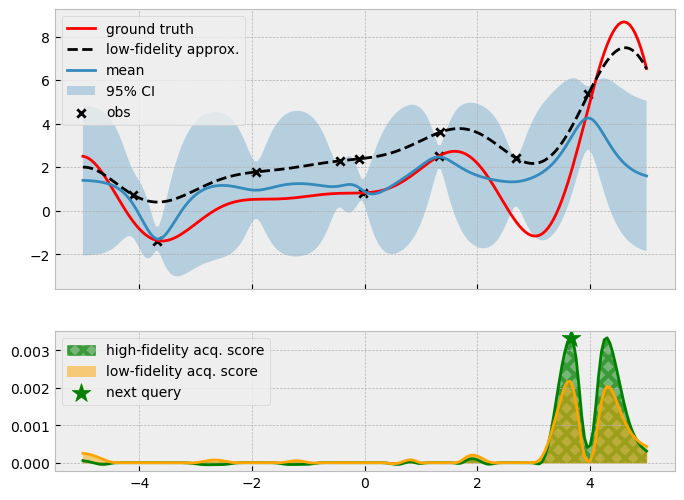

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 1]})

ax[0].plot(xs, ys, label="ground truth", c="r")
ax[0].plot(xs, approx_ys, "k--", label="low-fidelity approx.")

ax[0].plot(xs, pred_mean, label="mean")
ax[0].fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

ax[0].scatter(train_x, train_y, c="k", marker="x", label="obs")

ax[0].legend()

ax[1].plot(xs, highf_score, c="g")
ax[1].fill_between(
    xs.flatten(),
    highf_score,
    0,
    color="g",
    hatch="xx",
    alpha=0.5,
    label="high-fidelity acq. score",
)

ax[1].plot(xs, lowf_score, c="orange")
ax[1].fill_between(
    xs.flatten(),
    lowf_score,
    0,
    color="orange",
    alpha=0.5,
    label="low-fidelity acq. score",
)

ax[1].scatter(
    next_x.flatten()[0],
    acq_val,
    marker="*",
    s=200,
    c="g" if next_x.flatten()[1] == 1 else "orange",
    label="next query",
)

ax[1].legend();

In [15]:
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf


def get_final_recommendation(model):
    post_mean_policy = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=2,
        columns=[1],
        values=[1],
    )

    final_x, _ = optimize_acqf(
        post_mean_policy,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    return final_x


final_x = get_final_recommendation(model)
final_x

tensor([[3.9650]])

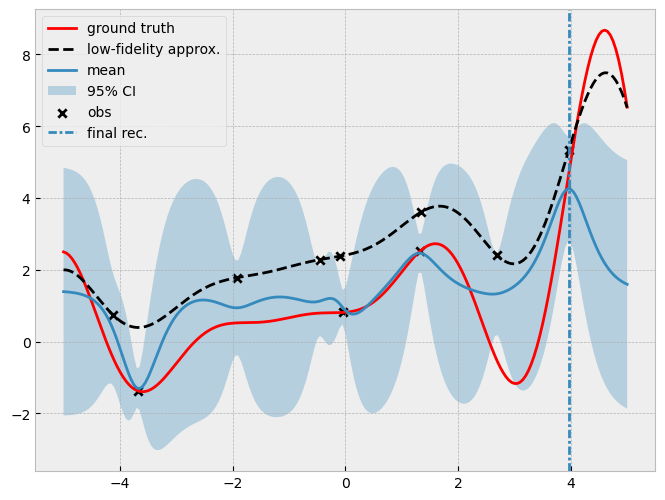

In [16]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

plt.scatter(train_x, train_y, c="k", marker="x", label="obs")
plt.axvline(final_x.item(), linestyle=(0, (3, 1, 1, 1)), label="final rec.")

plt.legend();